In [1]:
from google.cloud import storage
import json
import pandas as pd

# Initialize GCS client
client = storage.Client()
bucket_name = "finetune-data123"
bucket = client.bucket(bucket_name)

# Reference the file (blob) in the bucket
blob = bucket.blob("results/cleaned_summaries.jsonl")

# Download the content as a string
file_contents = blob.download_as_text()

# If you want to load it into a pandas DataFrame
df = pd.read_json(file_contents, lines=True)
print(df.head())

/tmp/ipython-input-1952671892.py:17: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(file_contents, lines=True)


   file_name                                               text  \
0          2  Summarize the following document: [1]\nBédard,...   
1         28  Summarize the following document:   <FRAGMENT_...   
2         31  Summarize the following document: I.\nIntroduc...   
3         54  Summarize the following document: [1]\nCullen,...   
4         68  Summarize the following document: [1]\nManson,...   

                                             summary  
0  The applicant is a Canadian citizen from Camer...  
1  This is an application for judicial review of ...  
2  This matter involves a question of a costs awa...  
3  This application was brought pursuant to s. 18...  
4  This is an application for judicial review of ...  


In [2]:
# Compute lengths of all texts
lengths = df['summary'].apply(len)

# Calculate statistics
average_length = lengths.mean()
min_length = lengths.min()
max_length = lengths.max()

print(f"Average length: {average_length}")
print(f"Minimum length: {min_length}")
print(f"Maximum length: {max_length}")

print(f"Lenght:{len(df)}")

Average length: 7266.813605442177
Minimum length: 122
Maximum length: 28680
Lenght:7350


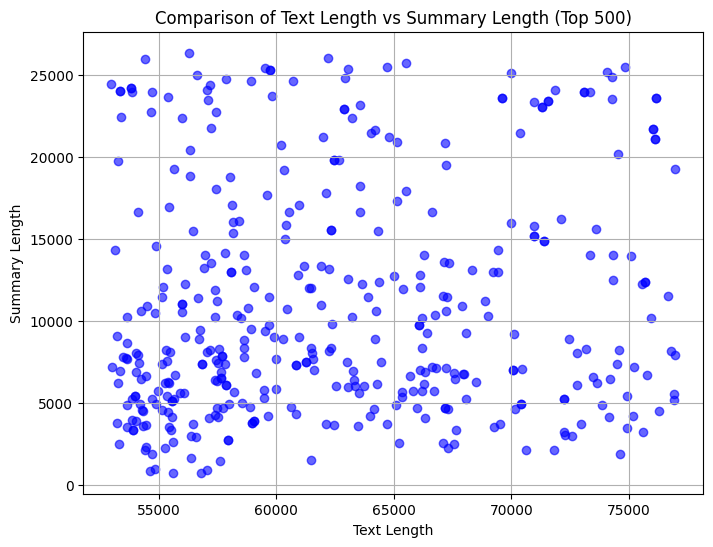

In [3]:
import matplotlib.pyplot as plt

# Compute lengths
df['text_length'] = df['text'].apply(len)
df['summary_length'] = df['summary'].apply(len)

# Sort by text length and take top 500
df_top500 = df.sort_values(by='text_length', ascending=False)
df_top500 = df_top500.iloc[299:700]

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(df_top500['text_length'], df_top500['summary_length'], alpha=0.6, color='blue')
plt.xlabel("Text Length")
plt.ylabel("Summary Length")
plt.title("Comparison of Text Length vs Summary Length (Top 500)")
plt.grid(True)
plt.show()


In [4]:
import pandas as pd
import uuid


# Drop the "text" column
df = df.drop(columns=["text"])

# Convert "file_name" to 6-digit string with leading zeros + ".txt"
df["file_name"] = df["file_name"].apply(lambda x: f"{int(x):06}.txt")

# Add unique _id column
df["_id"] = [str(uuid.uuid4()) for _ in range(len(df))]

# Optional: reorder columns (_id first)
df = df[["_id", "file_name", "summary"]]

print(df.head())


                                    _id   file_name  \
0  de07af9d-52de-43c5-9f99-dcc3dd4bb4b7  000002.txt   
1  9fccf491-7b42-4fba-989b-501a0de7e130  000028.txt   
2  a915481b-bd8d-499c-b9e5-39233678d230  000031.txt   
3  6a190925-f17d-4688-9d17-0b0e954acd61  000054.txt   
4  9cbccd3d-bf7a-450f-9f91-d9bbeaa24b7c  000068.txt   

                                             summary  
0  The applicant is a Canadian citizen from Camer...  
1  This is an application for judicial review of ...  
2  This matter involves a question of a costs awa...  
3  This application was brought pursuant to s. 18...  
4  This is an application for judicial review of ...  


In [5]:
!pip install nltk

In [ ]:
import uuid
import json
from tqdm import tqdm
from google.cloud import storage

from langchain.text_splitter import CharacterTextSplitter

# Define a text splitter with character-based chunking
text_splitter = CharacterTextSplitter(
    separator=".",       # try to break at sentence-like boundaries
    chunk_size=1500,     # max characters
    chunk_overlap=300,   # overlap
    length_function=len  # measure length in characters
)

def chunk_summary(summary):
    """
    Splits a summary into chunks using HuggingFace/LangChain's CharacterTextSplitter.
    """
    return text_splitter.split_text(summary)


# ---- Main Processing ----
all_chunks = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    summary_chunks = chunk_summary(row["summary"])
    for idx, chunk_text in enumerate(summary_chunks, start=1):
        chunk_data = {
            "_id": str(uuid.uuid4()),   # unique ID for the chunk
            "text": chunk_text,               # chunk text
            "file_path": row["file_name"],    # original file path
            "chunk_number": idx               # order in summary
        }
        all_chunks.append(chunk_data)

# Save to JSON
output_file = "chunked_summaries.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(all_chunks, f, ensure_ascii=False, indent=2)

print(f"Saved {len(all_chunks)} chunks to {output_file}")

# ---- Upload to GCS ----
bucket_name = "finetune-data123"
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob("chunked_summaries.json")
blob.upload_from_filename(output_file)

print(f"Uploaded to gs://{bucket_name}/chunked_summaries.json")


100%|██████████| 7350/7350 [00:01<00:00, 5043.44it/s]


Saved 46477 chunks to chunked_summaries.json
Uploaded to gs://finetune-data123/chunked_summaries.json


In [6]:
from google.cloud import storage
import json
import pandas as pd

bucket_name = "finetune-data123"
file_path = "chunked_summaries.json"

# Init client and get file
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)

# Download file contents
file_contents = blob.download_as_text()

# Load JSON
data = json.loads(file_contents)


In [ ]:
print(len(data))
print(data[:1])

46477
[{'_id': '31463db9-fc6c-4b87-957a-48400c543696', 'text': "The applicant is a Canadian citizen from Cameroon. In 2006, he adopted three children of his friend who had died in 2003. In 2008, the applicant took steps to sponsor and obtain visas for the three children for permanent residence in Canada under the family class. The Canadian Embassy in Abidjan rejected the application for permanent residence visas for the children on the grounds that they did not meet the requirements of membership in the family class. The officer determined that the adoption was neither valid nor genuine and was entered into primarily for the purpose of acquiring a status or privilege in relation to the Immigration and Refugee Protection Act (the Act). The applicant appealed this decision to the Immigration Appeal Division of the Immigration and Refugee Board of Canada (the IAD). The appeal was dismissed. The IAD held that the applicant had failed to establish that the children's adoption was legally va

In [ ]:
!pip install pinecone

In [ ]:
import json
import time
from pinecone import Pinecone

def upload_to_pinecone(data, key):
    path = "data/chunked/chunked_file2.json"
    pc = Pinecone(api_key=key)
    index = pc.Index(host="xxx")

    # Process in chunks
    chunk_size = 96  # Adjust based on your memory constraints
    records = []
    rate_limit_delay = 60
    for i in range(0, len(data), chunk_size):
      chunk = data[i:i + chunk_size]
      try:
          index.upsert_records("summary", chunk)
          time.sleep(1)
          print(f"Uploaded records {i} to {i+len(chunk)}")
      except Exception as e:
          if "RESOURCE_EXHAUSTED" in str(e):
              print(f"Rate limit hit, waiting {rate_limit_delay} seconds...")
              time.sleep(rate_limit_delay)
              # Retry the same chunk
              i -= chunk_size
          else:
              print(e)

#upload_to_pinecone(data, "")

In [ ]:
#evaluate the chunking summarizatino retrieval on the test database vs NORMAL REtrielval (one queries chunks, the other the summaries)

In [7]:
bucket_name = "finetune-data123"
file_name = "task1_train_labels_2025.json"

client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(file_name)

# Download and parse as dict
labels_content = blob.download_as_text()
labels = json.loads(labels_content)   # ✅ dict: { "file.txt": [ ... ] }

print(type(labels))          # <class 'dict'>
print(len(labels))           # number of keys
first_key = next(iter(labels))
print(first_key, "->", labels[first_key])

<class 'dict'>
1678
008447.txt -> ['072495.txt', '082291.txt', '004851.txt', '049315.txt']


In [ ]:
from google import genai
from google.genai import types
import base64
import time
from google.api_core import exceptions as g_exceptions

def generate_finetuned(text, retries=3, backoff=2):
    client = genai.Client(
        vertexai=True,
        project="651136027056",
        location="europe-west9",
    )

    model = "projects/651136027056/locations/europe-west9/endpoints/3743955839833079808"

    contents = [
        types.Content(
            role="user",
            parts=[types.Part.from_text(text=text)]
        )
    ]

    generate_content_config = types.GenerateContentConfig(
        temperature=0.0,
        top_p=0.95,
        max_output_tokens=50000,
        safety_settings=[
            types.SafetySetting(category="HARM_CATEGORY_HATE_SPEECH", threshold="OFF"),
            types.SafetySetting(category="HARM_CATEGORY_DANGEROUS_CONTENT", threshold="OFF"),
            types.SafetySetting(category="HARM_CATEGORY_SEXUALLY_EXPLICIT", threshold="OFF"),
            types.SafetySetting(category="HARM_CATEGORY_HARASSMENT", threshold="OFF"),
        ],
        thinking_config=types.ThinkingConfig(thinking_budget=0),
    )

    attempt = 0
    while attempt < retries:
        try:
            output_text = ""
            for chunk in client.models.generate_content_stream(
                model=model,
                contents=contents,
                config=generate_content_config,
            ):
                if chunk and getattr(chunk, "text", None):
                    output_text += chunk.text

            if not output_text.strip():
                raise ValueError("Empty response from model")

            return output_text  # ✅ Success, exit function

        except (g_exceptions.GoogleAPICallError, g_exceptions.RetryError,
                ValueError, Exception) as e:
            attempt += 1
            print(f"[Error] Attempt {attempt}/{retries} failed: {e}")

            if attempt < retries:
                sleep_time = backoff ** attempt
                print(f"Retrying in {sleep_time}s...")
                time.sleep(sleep_time)
            else:
                print("[Error] Max retries exceeded.")
                return "[Model error: no response]"


In [8]:
def load_case_text(file_name: str) -> str:
    """Load raw case text from bucket given filename like 000123.txt"""
    #rest of functino
    txt_blob = bucket.blob(f"task2025_train/{file_name}")  # adjust path if needed
    txt_blob.download_as_text()
    #from this dict extract "summary"
    content = txt_blob.download_as_text()
    #content = "Summarize the following document in a concise manner: " + content
    #summary = generate_finetuned(content)

    return content

In [9]:
def query_pinecone_chunks(text, file_path):
  pc = Pinecone(api_key="")
  index = pc.Index(host="")
  filtered_results = index.search(
  namespace="chunks",
  query={
    "inputs": {"text": text},
    "top_k": 15,
    "filter": {"file_path": {"$ne": file_path}},
    },
  fields=["file_path", "text"]
  )
  return filtered_results


In [10]:
def query_pinecone_summary(text, file_path):
  pc = Pinecone(api_key="")
  index = pc.Index(host="")
  filtered_results = index.search(
  namespace="summary",
  query={
    "inputs": {"text": text},
    "top_k": 15,
    "filter": {"file_path": {"$ne": file_path}},
    },
  fields=["file_path", "text"]
  )
  return filtered_results

In [22]:
def query_hybrid(text, file_path, top_k=15, rrf_k=60):
    """
    Hybrid retrieval using chunk and summary embeddings with Reciprocal Rank Fusion (RRF).

    Args:
        text (str): Query text.
        file_path (str): Current file to exclude from results.
        top_k (int): Number of top results to return.
        rrf_k (int): RRF parameter, usually 50-60.

    Returns:
        list of dict: Top results after hybrid ranking.
    """
    from collections import defaultdict

    # 1️⃣ Query both models
    chunk_results = query_pinecone_chunks(text, file_path)['result']['hits']
    summary_results = query_pinecone_summary(text, file_path)['result']['hits']

    # 2️⃣ Build RRF score table
    rrf_scores = defaultdict(float)

    def update_rrf(hits):
        for rank, hit in enumerate(hits, start=1):
            file_id = hit['fields']['file_path']
            rrf_scores[file_id] += 1 / (rrf_k + rank)

    update_rrf(chunk_results)
    update_rrf(summary_results)
    # 3️⃣ Sort by RRF score
    sorted_files = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)

    # 4️⃣ Fetch the full hit info for top_k files
    top_hits_dict = {}
    for hit in chunk_results + summary_results:
        file_id = hit['fields']['file_path']
        if file_id not in top_hits_dict:
            top_hits_dict[file_id] = hit

    top_hits = [top_hits_dict[file_id] for file_id, _ in sorted_files[:top_k]]

    return top_hits


In [21]:
def query_weighted_fusion(text, file_path, top_k=25, chunk_weight=0.5, summary_weight=0.5):
    chunk_results = query_pinecone_chunks(text, file_path)['result']['hits']
    summary_results = query_pinecone_summary(text, file_path)['result']['hits']

    # Normalize scores to 0-1 range
    def normalize_scores(hits):
        if not hits:
            return hits
        scores = [hit.get('score', hit.get('_score', 0)) for hit in hits]
        max_score = max(scores)
        min_score = min(scores)
        score_range = max_score - min_score if max_score != min_score else 1

        for i, hit in enumerate(hits):
            hit['normalized_score'] = (scores[i] - min_score) / score_range
        return hits

    chunk_results = normalize_scores(chunk_results)
    summary_results = normalize_scores(summary_results)

    # Combine scores
    file_scores = {}
    for hit in chunk_results:
        file_id = hit['fields']['file_path']
        file_scores[file_id] = hit['normalized_score'] * chunk_weight

    for hit in summary_results:
        file_id = hit['fields']['file_path']
        if file_id in file_scores:
            file_scores[file_id] += hit['normalized_score'] * summary_weight
        else:
            file_scores[file_id] = hit['normalized_score'] * summary_weight

    # Sort and return top_k
    sorted_files = sorted(file_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_files[:top_k]

In [23]:
from collections import defaultdict

def query_combsum(text, file_path, top_k=20):
    """CombSUM: Add normalized scores, CombMNZ: multiply by number of systems that retrieved it"""
    chunk_results = query_pinecone_chunks(text, file_path)['result']['hits']
    summary_results = query_pinecone_summary(text, file_path)['result']['hits']

    file_scores = defaultdict(lambda: {'score': 0, 'count': 0})

    for hit in chunk_results:
        file_id = hit['fields']['file_path']
        file_scores[file_id]['score'] += hit['_score']
        file_scores[file_id]['count'] += 1

    for hit in summary_results:
        file_id = hit['fields']['file_path']
        file_scores[file_id]['score'] += hit['_score']
        file_scores[file_id]['count'] += 1

    # CombSUM: just use score, CombMNZ: multiply by count
    final_scores = {
        file_id: data['score'] * data['count']  # CombMNZ
        # file_id: data['score']  # CombSUM
        for file_id, data in file_scores.items()
    }

    return sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

In [ ]:
def query_borda_count(text, file_path, top_k=20):
    """Assign points based on rank position"""
    chunk_results = query_pinecone_chunks(text, file_path)['result']['hits']
    summary_results = query_pinecone_summary(text, file_path)['result']['hits']

    file_scores = defaultdict(int)

    # Assign Borda points (higher rank = more points)
    for rank, hit in enumerate(chunk_results):
        file_id = hit['metadata']['file_path']
        file_scores[file_id] += len(chunk_results) - rank

    for rank, hit in enumerate(summary_results):
        file_id = hit['metadata']['file_path']
        file_scores[file_id] += len(summary_results) - rank

    return sorted(file_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

In [24]:
labels_subset = dict(list(labels.items())[:100])

In [15]:
!pip install pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.6/587.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.


In [20]:
import pandas as pd
import numpy as np
from pinecone import Pinecone



# Store results
eval_results = []
for key, relevant_files in labels_subset.items():
    # 1️⃣ Load the case summary text
    text = load_case_text(key)
    if not text:
        continue  # skip if summary is empty

    # 2️⃣ Query Pinecone
    print("Weighted 0.7/0.3 @15")
    top_results = query_weighted_fusion(text, key, top_k=15,chunk_weight=0.7, summary_weight=0.3)
    top_set = set(file_path for file_path, score in top_results)

    print("Weighted 0.5/0.5 @15")
    top_results = query_weighted_fusion(text, key, top_k=15,chunk_weight=0.5, summary_weight=0.5)
    top_set = set(file_path for file_path, score in top_results)
    print("Weighted 0.3/0.7 @15")
    top_results = query_weighted_fusion(text, key, top_k=15,chunk_weight=0.3, summary_weight=0.7)
    top_set = set(file_path for file_path, score in top_results)


    #top_results = query_hybrid(text, key, top_k=15, rrf_k=60)
    #top_set = set(hit['fields']['file_path'] for hit in top_results)

    #top_results = query_combsum(text, key, top_k=20)
    #top_set = set(file_path for file_path, score in top_results)

    #print("computing query_borda_count")
    #top_results = query_combsum(text, key, top_k=20)
    #top_set = set(file_path for file_path, score in top_results)

    # 3️⃣ Compute precision and recall
    #top_results = query_pinecone_summary(text, key)
    #top_set = set(hit['fields']['file_path'] for hit in top_results['result']['hits'])
    label_set = set(relevant_files)

    true_positives = len(top_set & label_set)
    precision = true_positives / len(top_set) if top_set else 0
    recall = true_positives / len(label_set) if label_set else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    eval_results.append({
        "file_name": key,
        "top_results": top_results,
        "label_files": relevant_files,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

# 4️⃣ Convert to DataFrame
df_eval = pd.DataFrame(eval_results)

# 5️⃣ Optional: compute average metrics
avg_precision = np.mean(df_eval["precision"])
avg_recall = np.mean(df_eval["recall"])
avg_f1 = np.mean(df_eval["f1"])
print(f"Average precision: {avg_precision:.3f}, Average recall: {avg_recall:.3f}, Average f1:{avg_f1}")

# 6️⃣ View sample
#print(df_eval)


0
[0.6454991102218628, 0.6306661367416382, 0.6222212314605713, 0.6143912076950073, 0.6136763095855713, 0.6111672520637512, 0.6105512976646423, 0.6074427962303162, 0.5956488251686096, 0.5955730080604553, 0.5910812020301819, 0.5885016918182373, 0.5818704962730408, 0.578586220741272, 0.5763973593711853]
[0.6431240439414978, 0.5962752103805542, 0.5883187055587769, 0.5880669951438904, 0.5870196223258972, 0.5840811133384705, 0.5821640491485596, 0.5794183611869812, 0.5768793821334839, 0.5756206512451172, 0.5755482912063599, 0.5698968172073364, 0.5694072246551514, 0.5626993775367737, 0.5586159229278564]
1
[0.6388542056083679, 0.6387531161308289, 0.6151907444000244, 0.6146493554115295, 0.6062570214271545, 0.5987225770950317, 0.5973066091537476, 0.5970333218574524, 0.5956684947013855, 0.5925416946411133, 0.5915898680686951, 0.5909869074821472, 0.5904958248138428, 0.5897932052612305, 0.5893498659133911]
[0.7008123993873596, 0.6447268724441528, 0.6347314119338989, 0.6324806213378906, 0.63247781991

In [25]:
# Define the weight combinations
weight_combinations = [
    {"chunk_weight": 0.7, "summary_weight": 0.3, "label": "0.7/0.3"},
    {"chunk_weight": 0.5, "summary_weight": 0.5, "label": "0.5/0.5"},
    {"chunk_weight": 0.3, "summary_weight": 0.7, "label": "0.3/0.7"},
]

# Store results
eval_results = []

for key, relevant_files in labels_subset.items():
    # 1️⃣ Load the case summary text
    text = load_case_text(key)
    if not text:
        continue  # skip if summary is empty

    label_set = set(relevant_files)

    for combo in weight_combinations:
        print(f"Evaluating weighted {combo['label']} @15")
        top_results = query_weighted_fusion(
            text, key, top_k=15,
            chunk_weight=combo["chunk_weight"],
            summary_weight=combo["summary_weight"]
        )
        top_set = set(file_path for file_path, score in top_results)

        # 3️⃣ Compute precision, recall, F1
        true_positives = len(top_set & label_set)
        precision = true_positives / len(top_set) if top_set else 0
        recall = true_positives / len(label_set) if label_set else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        eval_results.append({
            "file_name": key,
            "weight_combo": combo["label"],
            "top_results": top_results,
            "label_files": relevant_files,
            "precision": precision,
            "recall": recall,
            "f1": f1
        })

# 4️⃣ Convert to DataFrame
df_eval = pd.DataFrame(eval_results)

# 5️⃣ Optional: compute average metrics per weight combination
avg_metrics = df_eval.groupby("weight_combo")[["precision", "recall", "f1"]].mean()
print(avg_metrics)


Evaluating weighted 0.7/0.3 @15
Evaluating weighted 0.5/0.5 @15
Evaluating weighted 0.3/0.7 @15
Evaluating weighted 0.7/0.3 @15
Evaluating weighted 0.5/0.5 @15
Evaluating weighted 0.3/0.7 @15
Evaluating weighted 0.7/0.3 @15
Evaluating weighted 0.5/0.5 @15
Evaluating weighted 0.3/0.7 @15
Evaluating weighted 0.7/0.3 @15
Evaluating weighted 0.5/0.5 @15
Evaluating weighted 0.3/0.7 @15
Evaluating weighted 0.7/0.3 @15
Evaluating weighted 0.5/0.5 @15
Evaluating weighted 0.3/0.7 @15
Evaluating weighted 0.7/0.3 @15
Evaluating weighted 0.5/0.5 @15
Evaluating weighted 0.3/0.7 @15
Evaluating weighted 0.7/0.3 @15
Evaluating weighted 0.5/0.5 @15
Evaluating weighted 0.3/0.7 @15
Evaluating weighted 0.7/0.3 @15
Evaluating weighted 0.5/0.5 @15
Evaluating weighted 0.3/0.7 @15
Evaluating weighted 0.7/0.3 @15
Evaluating weighted 0.5/0.5 @15
Evaluating weighted 0.3/0.7 @15
Evaluating weighted 0.7/0.3 @15
Evaluating weighted 0.5/0.5 @15
Evaluating weighted 0.3/0.7 @15
Evaluating weighted 0.7/0.3 @15
Evaluati

Average precision: 0.053, Average recall: 0.213, Average f1:0.07017527759584703 - summary
Average precision: 0.077, Average recall: 0.228, Average f1:0.10055213115769324 9 - Chunks (20)
Average precision: 0.082, Average recall: 0.188, Average f1:0.0996866746346488 15 chunks
Average precision: 0.082, Average recall: 0.188, Average f1:0.0996866746346488 - HYBRID (Same?)
Average precision: 0.130, Average recall: 0.359, Average f1:0.18282939282939287
-15 chunks

EVAl
@15
1. Chunks only @15
Average precision: 0.130, Average recall: 0.359, Average f1:0.18282939282939287

2. h Reciprocal Rank Fusion (RRF) (rrf_k - 60) (@15)
Average precision: 0.102, Average recall: 0.470, Average f1:0.16215713518150845

2.11 h Reciprocal Rank Fusion (RRF) (rrf_k - 60) (@10)(topk-10)
Average precision: 0.109, Average recall: 0.328, Average f1:0.1564647852147852

2.21 h Reciprocal Rank Fusion (RRF) (rrf_k - 60) (@20)(topk-10)
Average precision: 0.118, Average recall: 0.399, Average f1:0.1745109873786344

2.1  Reciprocal Rank Fusion (RRF) (rrf_k - 60) (@50)
Average precision: 0.080, Average recall: 0.530, Average f1:0.1351794392236671

3. Weighted Fusion (chunk_weight=0.3, summary_weight=0.7)
Average precision: 0.102, Average recall: 0.470, Average f1:0.16215713518150845

3.1 Weighted Fusion (chunk_weight=0.5, summary_weight=0.5)
Average precision: 0.100, Average recall: 0.454, Average f1:0.15780930909455193

3.2 Weighted Fusion (chunk_weight=0.7, summary_weight=0.3)
Average precision: 0.100, Average recall: 0.454, Average f1:0.15780930909455193

4 Combsum
Average precision: 0.097, Average recall: 0.448, Average f1:0.15436103323248296


EVAL WITH SUMMARIES
Average precision: 0.070, Average recall: 0.303, Average f1:0.1099108297166768

In [ ]:
print(df_eval)

    file_name                                        top_results  \
0  008447.txt  {'result': {'hits': [{'_id': '29aa7d44-9f7e-48...   
1  067501.txt  {'result': {'hits': [{'_id': '2ba02262-e7ac-4e...   
2  007627.txt  {'result': {'hits': [{'_id': '15d604d1-d510-4a...   
3  006769.txt  {'result': {'hits': [{'_id': '906a15d6-c175-40...   
4  007876.txt  {'result': {'hits': [{'_id': '5d0022d2-6cb4-41...   
5  078422.txt  {'result': {'hits': [{'_id': 'a4ba2a14-c8c8-43...   
6  000123.txt  {'result': {'hits': [{'_id': '5c55ef7e-e6fe-46...   
7  043774.txt  {'result': {'hits': [{'_id': 'a1ff50a9-960a-45...   
8  031183.txt  {'result': {'hits': [{'_id': '121d1b6f-085a-48...   
9  039087.txt  {'result': {'hits': [{'_id': 'e0a5f31d-cd39-40...   

                                         label_files  precision    recall  
0   [072495.txt, 082291.txt, 004851.txt, 049315.txt]   0.000000  0.000000  
1                           [038025.txt, 072553.txt]   0.000000  0.000000  
2                      

In [ ]:
!pip install pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.6/587.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import json
import math
from collections import defaultdict, Counter
from pinecone import Pinecone
from google.cloud import storage
from typing import List, Dict, Tuple, Any

# ========================================
# DATA LOADING AND SETUP
# ========================================

# Google Cloud Storage setup
bucket_name = "finetune-data123"
file_name = "task1_train_labels_2025.json"

client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(file_name)

# Download and parse labels
labels_content = blob.download_as_text()
labels = json.loads(labels_content)   # ✅ dict: { "file.txt": [ ... ] }

print(f"Loaded {len(labels)} labeled cases")
first_key = next(iter(labels))
print(f"Sample: {first_key} -> {len(labels[first_key])} relevant files")

def load_case_text(file_name: str) -> str:
    """Load raw case text from bucket given filename like 000123.txt"""
    try:
        txt_blob = bucket.blob(f"task2025_train/{file_name}")
        content = txt_blob.download_as_text()
        return content
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return ""

# ========================================
# PINECONE QUERY FUNCTIONS
# ========================================

def query_pinecone_summary(text, file_path):
    """Query summary namespace"""
    pc = Pinecone(api_key="pcsk_5QU4a5_EM7gfZXyH3JRDMuXQoGCDd3DLkiHWboRS8ahW11Qk89v2xffqWS3tYCfZgSGs2Y")
    index = pc.Index(host="https://experiment2-cpullh2.svc.apu-57e2-42f6.pinecone.io")
    filtered_results = index.search(
        namespace="summary",
        query={
            "inputs": {"text": text},
            "top_k": 150,
            "filter": {"file_path": {"$ne": file_path}},
        },
        fields=["file_path", "text"]
    )
    return filtered_results

def query_pinecone_chunks(text, file_path):
    """Query chunks namespace"""
    pc = Pinecone(api_key="pcsk_5QU4a5_EM7gfZXyH3JRDMuXQoGCDd3DLkiHWboRS8ahW11Qk89v2xffqWS3tYCfZgSGs2Y")
    index = pc.Index(host="https://experiment2-cpullh2.svc.apu-57e2-42f6.pinecone.io")
    filtered_results = index.search(
        namespace="chunks",
        query={
            "inputs": {"text": text},
            "top_k": 150,
            "filter": {"file_path": {"$ne": file_path}},
        },
        fields=["file_path", "text"]
    )
    return filtered_results

# ========================================
# ADVANCED RANKING FUSION ALGORITHMS
# ========================================

def normalize_scores(scores: List[float], method: str = "min_max") -> List[float]:
    """Normalize scores using different methods"""
    scores = np.array(scores)

    if method == "min_max":
        if len(scores) > 1 and scores.max() != scores.min():
            return ((scores - scores.min()) / (scores.max() - scores.min())).tolist()
        else:
            return scores.tolist()
    elif method == "z_score":
        if scores.std() > 0:
            return ((scores - scores.mean()) / scores.std()).tolist()
        else:
            return scores.tolist()
    elif method == "rank":
        # Convert to rank-based scores (higher rank = better)
        ranks = len(scores) - np.argsort(np.argsort(-scores))
        return (ranks / len(scores)).tolist()
    else:
        return scores.tolist()

def reciprocal_rank_fusion(ranked_lists: List[List[Tuple[str, float]]], k: int = 60) -> List[Tuple[str, float]]:
    """
    Reciprocal Rank Fusion algorithm
    Args:
        ranked_lists: List of ranked lists, each containing (file_path, score) tuples
        k: RRF parameter (typically 60)
    """
    rrf_scores = defaultdict(float)

    for ranked_list in ranked_lists:
        for rank, (file_path, score) in enumerate(ranked_list, 1):
            rrf_scores[file_path] += 1.0 / (k + rank)

    # Sort by RRF score descending
    return sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)

def combsum_fusion(score_lists: List[List[Tuple[str, float]]], weights: List[float] = None) -> List[Tuple[str, float]]:
    """CombSUM fusion - sum normalized scores"""
    if weights is None:
        weights = [1.0] * len(score_lists)

    # Normalize each list
    normalized_lists = []
    for score_list in score_lists:
        if score_list:
            scores = [score for _, score in score_list]
            norm_scores = normalize_scores(scores, "min_max")
            normalized_lists.append([(file_path, norm_score) for (file_path, _), norm_score in zip(score_list, norm_scores)])
        else:
            normalized_lists.append([])

    # Combine scores
    combined_scores = defaultdict(float)
    for weight, score_list in zip(weights, normalized_lists):
        for file_path, score in score_list:
            combined_scores[file_path] += weight * score

    return sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

def aggregate_chunk_scores(chunk_results: List[Dict], aggregation_method: str = "max") -> List[Tuple[str, float]]:
    """Aggregate chunk scores by file_path to represent complete cases"""
    file_scores = defaultdict(list)

    for hit in chunk_results.get('result', {}).get('hits', []):
        file_path = hit['fields']['file_path']
        score = hit['_score']
        file_scores[file_path].append(score)

    aggregated = []
    for file_path, scores in file_scores.items():
        if aggregation_method == "max":
            agg_score = max(scores)
        elif aggregation_method == "mean":
            agg_score = np.mean(scores)
        elif aggregation_method == "sum":
            agg_score = sum(scores)
        elif aggregation_method == "weighted_sum":
            # Weight by number of chunks (more chunks = higher confidence)
            agg_score = sum(scores) * math.log(len(scores) + 1)
        else:
            agg_score = max(scores)

        aggregated.append((file_path, agg_score))

    return sorted(aggregated, key=lambda x: x[1], reverse=True)

def extract_results_list(results: Dict) -> List[Tuple[str, float]]:
    """Extract (file_path, score) tuples from Pinecone results"""
    return [(hit['fields']['file_path'], hit['_score'])
            for hit in results.get('result', {}).get('hits', [])]

# ========================================
# MAIN HYBRID RERANKER
# ========================================

def query_hybrid_advanced(text: str, file_path: str, top_k: int = 10) -> List[Dict]:
    """
    Advanced hybrid reranker combining summary and chunk results

    Args:
        text: Query text
        file_path: Current file path to exclude
        top_k: Number of top results to return

    Returns:
        List of top ranked results with metadata
    """

    # 1. Query both namespaces
    print("Querying summary namespace...")
    summary_results = query_pinecone_summary(text, file_path)

    print("Querying chunks namespace...")
    chunk_results = query_pinecone_chunks(text, file_path)

    # 2. Extract and process results
    summary_list = extract_results_list(summary_results)
    chunk_list = extract_results_list(chunk_results)

    # 3. Aggregate chunk scores by file_path (prioritize cases over individual chunks)
    print("Aggregating chunk scores by case...")
    aggregated_chunks = aggregate_chunk_scores(chunk_results, "weighted_sum")

    # 4. Apply multiple fusion techniques
    fusion_results = {}

    # Method 1: Reciprocal Rank Fusion
    print("Applying Reciprocal Rank Fusion...")
    rrf_results = reciprocal_rank_fusion([summary_list, aggregated_chunks], k=60)
    fusion_results['rrf'] = rrf_results

    # Method 2: Weighted CombSUM (prioritize summaries over chunks)
    print("Applying Weighted CombSUM...")
    combsum_results = combsum_fusion([summary_list, aggregated_chunks], weights=[0.7, 0.3])
    fusion_results['combsum'] = combsum_results

    # Method 3: Borda Count
    print("Applying Borda Count...")
    def borda_count(ranked_lists):
        borda_scores = defaultdict(float)
        for ranked_list in ranked_lists:
            max_rank = len(ranked_list)
            for rank, (file_path, _) in enumerate(ranked_list):
                borda_scores[file_path] += max_rank - rank
        return sorted(borda_scores.items(), key=lambda x: x[1], reverse=True)

    borda_results = borda_count([summary_list, aggregated_chunks])
    fusion_results['borda'] = borda_results

    # 5. Meta-fusion: Combine different fusion methods
    print("Applying meta-fusion...")
    meta_fusion_input = [
        fusion_results['rrf'][:50],
        fusion_results['combsum'][:50],
        fusion_results['borda'][:50]
    ]

    final_rrf = reciprocal_rank_fusion(meta_fusion_input, k=30)

    # 6. Boost summary results (since they represent complete cases)
    print("Applying case-level boosting...")
    summary_files = set(file_path for file_path, _ in summary_list)

    boosted_results = []
    for file_path, score in final_rrf:
        if file_path in summary_files:
            # Boost score for files that have summaries (complete cases)
            boosted_score = score * 1.2
        else:
            boosted_score = score
        boosted_results.append((file_path, boosted_score))

    # Sort by boosted scores
    boosted_results.sort(key=lambda x: x[1], reverse=True)

    # 7. Prepare final results with metadata
    final_results = []
    summary_texts = {}
    chunk_texts = defaultdict(list)

    # Collect text content for context
    for hit in summary_results.get('result', {}).get('hits', []):
        summary_texts[hit['fields']['file_path']] = hit['fields'].get('text', '')

    for hit in chunk_results.get('result', {}).get('hits', []):
        chunk_texts[hit['fields']['file_path']].append(hit['fields'].get('text', ''))

    for i, (file_path, final_score) in enumerate(boosted_results[:top_k]):
        result = {
            'rank': i + 1,
            'fields': {'file_path': file_path},
            'score': final_score,
            'has_summary': file_path in summary_texts,
            'summary_text': summary_texts.get(file_path, ''),
            'chunk_count': len(chunk_texts.get(file_path, [])),
            'sample_chunks': chunk_texts.get(file_path, [])[:3],  # First 3 chunks as sample
            'fusion_scores': {
                'rrf': dict(fusion_results['rrf']).get(file_path, 0),
                'combsum': dict(fusion_results['combsum']).get(file_path, 0),
                'borda': dict(fusion_results['borda']).get(file_path, 0)
            }
        }
        final_results.append(result)

    print(f"Hybrid reranking complete. Returning top {len(final_results)} results.")
    return final_results

# ========================================
# EVALUATION FUNCTIONS
# ========================================

def run_single_example():
    """Run a single example with detailed output"""
    print("\n" + "="*60)
    print("RUNNING SINGLE EXAMPLE")
    print("="*60)

    # Pick a real example from your labels
    example_file = first_key
    relevant_files = labels[example_file]

    print(f"Query file: {example_file}")
    print(f"Known relevant files: {len(relevant_files)} total")
    print(f"Sample relevant files: {relevant_files[:3]}...")

    # Load the actual text content
    try:
        query_text = load_case_text(example_file)
        print(f"Loaded text length: {len(query_text)} characters")
        print(f"Text preview: {query_text[:200]}...")

        # Query using the hybrid reranker
        print(f"\n{'='*40}")
        print("QUERYING HYBRID RERANKER")
        print("="*40)

        results = query_hybrid_advanced(
            text=query_text,
            file_path=example_file,
            top_k=10
        )

        # Evaluate results
        returned_files = [hit['fields']['file_path'] for hit in results]
        known_relevant = set(relevant_files)
        returned_set = set(returned_files)

        matches = returned_set & known_relevant
        precision = len(matches) / len(returned_set) if returned_set else 0
        recall = len(matches) / len(known_relevant) if known_relevant else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\n{'='*40}")
        print("EVALUATION RESULTS")
        print("="*40)
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-Score: {f1:.3f}")
        print(f"Matches found: {len(matches)} out of {len(returned_set)} returned")
        print(f"Total relevant cases: {len(known_relevant)}")

        print(f"\nTOP 10 RESULTS:")
        print("-" * 80)
        for i, result in enumerate(results, 1):
            file_path = result['fields']['file_path']
            score = result['score']
            is_relevant = "✓ RELEVANT" if file_path in known_relevant else "✗ Not relevant"
            has_summary = "📄 Summary" if result['has_summary'] else "📋 Chunks only"

            print(f"{i:2d}. {file_path}")
            print(f"    Score: {score:.4f} | {is_relevant} | {has_summary}")
            print(f"    Chunk count: {result['chunk_count']}")

            # Show content preview
            if result['summary_text']:
                print(f"    Summary: {result['summary_text'][:120]}...")
            elif result['sample_chunks']:
                print(f"    Sample: {result['sample_chunks'][0][:120]}...")
            print()

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'matches': matches,
            'results': results
        }

    except Exception as e:
        print(f"Error: {e}")
        return None

def run_full_evaluation(subset_size=None):
    """Run evaluation on subset or full dataset"""
    print(f"\n{'='*60}")
    print("RUNNING FULL EVALUATION")
    print("="*60)

    # Use subset or full dataset
    if subset_size:
        sample_keys = list(labels.keys())[:subset_size]
        print(f"Evaluating on {subset_size} cases...")
    else:
        sample_keys = list(labels.keys())
        print(f"Evaluating on all {len(sample_keys)} cases...")

    eval_results = []

    for i, key in enumerate(sample_keys):
        print(f"\nProcessing {i+1}/{len(sample_keys)}: {key}")

        try:
            # Load case text
            text = load_case_text(key)
            if not text:
                print(f"  Skipping - no text content")
                continue

            # Query hybrid reranker
            top_results = query_hybrid_advanced(text, key, top_k=10)
            top_set = set(hit['fields']['file_path'] for hit in top_results)

            # Compute metrics
            label_set = set(labels[key])
            true_positives = len(top_set & label_set)
            precision = true_positives / len(top_set) if top_set else 0
            recall = true_positives / len(label_set) if label_set else 0
            f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            eval_results.append({
                "file_name": key,
                "top_results": top_results,
                "label_files": labels[key],
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "matches": true_positives,
                "total_relevant": len(label_set)
            })

            print(f"  P: {precision:.3f}, R: {recall:.3f}, F1: {f1:.3f}, Matches: {true_positives}/{len(label_set)}")

        except Exception as e:
            print(f"  Error: {e}")
            continue

    # Compute and display results
    if eval_results:
        df_eval = pd.DataFrame(eval_results)

        avg_precision = np.mean(df_eval["precision"])
        avg_recall = np.mean(df_eval["recall"])
        avg_f1 = np.mean(df_eval["f1"])
        total_matches = df_eval["matches"].sum()
        total_returned = len(eval_results) * 10  # 10 results per query
        total_relevant = df_eval["total_relevant"].sum()

        print(f"\n{'='*60}")
        print("FINAL RESULTS")
        print("="*60)
        print(f"Evaluated {len(eval_results)} cases")
        print(f"Average Precision: {avg_precision:.3f}")
        print(f"Average Recall: {avg_recall:.3f}")
        print(f"Average F1: {avg_f1:.3f}")
        print(f"Total matches: {total_matches}")
        print(f"Total returned: {total_returned}")
        print(f"Total relevant: {total_relevant}")
        print(f"Overall precision: {total_matches/total_returned:.3f}")

        return df_eval
    else:
        print("No successful evaluations!")
        return None

# ========================================
# MAIN EXECUTION
# ========================================

if __name__ == "__main__":
    print("Advanced Hybrid Reranker System")
    print("="*60)

    # Run single example first
    single_result = run_single_example()

    # Ask user for full evaluation
    print(f"\n{'='*60}")
    user_input = input("Run full evaluation? Enter number of cases (or 'all' for full dataset, 'skip' to skip): ").strip().lower()

    if user_input == 'skip':
        print("Skipping full evaluation.")
    elif user_input == 'all':
        df_results = run_full_evaluation()
    else:
        try:
            subset_size = int(user_input)
            df_results = run_full_evaluation(subset_size)
        except ValueError:
            print("Invalid input. Running on 5 samples as default.")
            df_results = run_full_evaluation(5)

    print("\nSystem ready for additional queries!")
    print("Use: results = query_hybrid_advanced(text, file_path, top_k=10)")

Loaded 1678 labeled cases
Sample: 008447.txt -> 4 relevant files
Advanced Hybrid Reranker System

RUNNING SINGLE EXAMPLE
Query file: 008447.txt
Known relevant files: 4 total
Sample relevant files: ['072495.txt', '082291.txt', '004851.txt']...
Loaded text length: 24793 characters
Text preview:  
 
 
 
 
 
 
 
 Yoon v. Can. (M.C.I.) (2012), 405 F.T.R. 139 (FC) 
 
 
 
 MLB headnote and full text 
 
 
 
 [French language version follows English language version] 
 
 
 
 [La...

QUERYING HYBRID RERANKER
Querying summary namespace...
Querying chunks namespace...
Aggregating chunk scores by case...
Applying Reciprocal Rank Fusion...
Applying Weighted CombSUM...
Applying Borda Count...
Applying meta-fusion...
Applying case-level boosting...
Hybrid reranking complete. Returning top 10 results.

EVALUATION RESULTS
Precision: 0.200
Recall: 0.500
F1-Score: 0.286
Matches found: 2 out of 10 returned
Total relevant cases: 4

TOP 10 RESULTS:
------------------------------------------------------------